In [1]:
# Python
import os
import random

# Pandas
import pandas as pd
from dateutil import tz

# Numpy
import numpy as np

# SciPy
from scipy.optimize import curve_fit

# Constants
from scipy import constants as Constants

# Matplotlib
import matplotlib.pyplot as plt
font = {'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
import matplotlib.image as pltimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

%matplotlib inline

/home/kos/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Read in list of sensor coordinates and make a dictionary mapping sensor name to coordinate

In [2]:
dfn = pd.read_csv('data/sensor_list_new_with_name',sep=',')

In [3]:
name_dict = {}
for i,j,k in zip(dfn['name'],dfn['x'],dfn['y']):
    name_dict[i] = [j,k]

## Read in json of old sensor data, and map sensor id to new sensor coordinates using the sensor name

In [4]:
import json
with open('data/sensor_coord.json') as json_data:
    sensor_read = json.load(json_data)

In [5]:
sensors = []
for value, k in sensor_read.iteritems():
    sensors.append({'sensor' : value, 'x' : name_dict[sensor_read[value]['name']][0],
                    'y' : name_dict[sensor_read[value]['name']][1], 
                    'z' : sensor_read[value]['coordinates']['internal'][2]})
sensors_df = pd.DataFrame(sensors)
sensors_df.set_index('sensor', inplace=True)

## Get the raw data that contains the received signal strength of all the sensors

In [6]:
raw_data_df = pd.read_csv('data/cb035_raw_Jan23')

In [7]:
raw_data_df.drop(raw_data_df.columns[[0]], axis=1, inplace=True)
raw_data_df.sort_values(['measurementTimestamp'], inplace=True)

## Only keep measurements that have a signal strength of -70 dBm or higher

In [8]:
raw_data_df = raw_data_df[raw_data_df['signal'] >= -70]

## Import libraries from the ROOT analysis package for doing the minimization

In [9]:
# from ROOT import *
from ROOT import TMinuit
from ROOT import TCanvas
from ROOT import TF1
from array import array;
import ctypes

ncount = 0

Welcome to JupyROOT 6.09/01


## Function that takes in data, sensor information and does the Chi2 minimization

In [10]:
def do_full_fit(meas_list, sense_coord_list_x, sense_coord_list_y, eps_list,seedx,seedy):
    errorz = array( 'f', len(sense_coord_list_x)*[sensor_res] ) # per sensor noise    
    listchi2 = []
    listns = []
    ndev = len(meas_list)
    def fcn( npar, gin, f, par, iflag ):
        global ncount
        # calculate chisquare
        chisq, delta = 0., 0.
        cnter = 0
        for i in range(ndev):
            tm = meas_list[i]
            senx = sense_coord_list_x[i]
            seny = sense_coord_list_y[i]
            delta  = (tm-func(senx+par[3],seny+par[4],par[0],par[1],2.0-eps_list[i],par[2]))/errorz[0]
            chisq += delta*delta
            cnter += 1

        f[0] = chisq
        listchi2.append(chisq)
        listns.append(cnter)
        
        ncount += 1

    def func(sx, sy, px, py, par, par2):
        sT = 10
        wL = 0.125
        fpi = np.pi*4.0
        radi = np.sqrt(np.power(sx-px,2) + np.power(sy-py,2))
        eps = par
        rho = par2
        sig_rec = rho - 10.0*(2.0+eps)*np.log10(radi)
        return sig_rec
    
    def testfit():
        gMinuit = TMinuit(5)
        gMinuit.SetFCN( fcn )

        arglist = array( 'd', 10*[0.] )
        ierflg = ctypes.c_int(1982)

        arglist[0] = 1
        gMinuit.mnexcm( "SET ERR", arglist, 1, ierflg )
        gMinuit.mnparm(0, "x", seedx, 1.0, seedx-25, seedx+25, ierflg )  
        gMinuit.mnparm(1, "y", seedy, 1.0, seedy-25, seedy+25, ierflg )
        gMinuit.mnparm(2, "pT", -30, 0.1, -60, 0, ierflg )
        gMinuit.mnparm(3, "dX", 0.0, 0.1, -10, 10, ierflg )
        gMinuit.mnparm(4, "dY", 0.0, 0.1, -10, 10, ierflg )
        gMinuit.FixParameter(3)
        gMinuit.FixParameter(4)
        # Now ready for minimization step
        arglist[0] = 250
        arglist[1] = 1.
        gMinuit.SetMaxIterations(250)
        gMinuit.mnexcm( "MIGRAD", arglist, 2, ierflg )
        xps = ctypes.c_double(0.0)
        exps = ctypes.c_double(0.0)
        yps = ctypes.c_double(0.0)
        eyps = ctypes.c_double(0.0)
        pts = ctypes.c_double(0.0)
        epts = ctypes.c_double(0.0)
        gMinuit.GetParameter(0,xps,exps)
        gMinuit.GetParameter(1,yps,eyps)
        gMinuit.GetParameter(2,pts,epts)
        
        return xps, yps, pts, ierflg.value
    
    px, py, tp, fstatus = testfit()
    minchi = min(listchi2)
    chindfdict = dict(zip(listchi2,listns))
    return px, py, tp, minchi, chindfdict[minchi], fstatus

## set sensor resolution for fit,  and time grouping of measurements to 500 ms

In [11]:
sensor_res = 3.0
timing_msec = 500
time_group = str(timing_msec) + 'ms'

In [12]:
raw_data_df['mtime'] = pd.to_datetime(raw_data_df.measurementTimestamp, unit='ms')
raw_data_df.set_index('mtime', inplace=True)

In [13]:
raw_data_grps = raw_data_df.groupby([pd.TimeGrouper(time_group),'sourceMac'])

In [14]:
import operator
xlist = []
ylist = []
chilist = []
ndflist = []
tplist = []
mslist = []
senselist = []
fitlist = []
fitmac = []
for time, group in raw_data_grps:
    meas_list = array('f', [])
    siglist = []
    sense_coord_list_x = array('f',[])
    sense_coord_list_y = array('f',[])
    sense_list = []
    eps_list = array('f',[])
    droneSig = {}
    if (group.droneId.unique().size > 3) & (group.size > 3): 
        droneMax = -999
        maxDrone = ""
        xnum = 0
        ynum = 0
        xsum = 0
        ysum = 0
        for r in group.itertuples():
                # print(r)
            meas_list.append(r[6])
            siglist.append(r[6])
            xpos = sensors_df.at[r[4],'x']
            ypos = sensors_df.at[r[4],'y']
            xnum += xpos
            ynum += ypos
            xsum += 1.0
            ysum += 1.0
            tmpc = array('f', (xpos, ypos))
            sense_coord_list_x.append(xpos)
            sense_coord_list_y.append(ypos)
            sense_list.append(r[4])
            # set all the environmental parameters to free space
            eps_list.append(2.0)
            # eps_list.append(df_env_dict[r[4]])
            
            if r[6] > droneMax:
                maxDrone = r[4]
                droneMax = r[6]
        
        
        seedx = xnum/xsum
        seedy = ynum/ysum
        px, py, tp, chi2, ndf, ft = do_full_fit(meas_list, sense_coord_list_x, 
                                            sense_coord_list_y, eps_list,seedx,seedy)
        xlist.append(px)
        ylist.append(py)
        chilist.append(chi2)
        tplist.append(tp)
        ndflist.append(ndf)
        senselist.append(sense_list)
        mslist.append(siglist)
        fitlist.append(ft)
        fitmac.append(time[1])
                

 **********
 **    1 **SET ERR           1
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 x            2.48621e+00  1.00000e+00   -2.25138e+01  2.74862e+01
     2 y           -9.34448e+00  1.00000e+00   -3.43445e+01  1.56555e+01
     3 pT          -3.00000e+01  1.00000e-01   -6.00000e+01  0.00000e+00
     4 dX           0.00000e+00  1.00000e-01   -1.00000e+01  1.00000e+01
     5 dY           0.00000e+00  1.00000e-01   -1.00000e+01  1.00000e+01
 **********
 **    2 **FIX           4
 **********
 **********
 **    3 **FIX           5
 **********
 **********
 **    4 **MIGRAD         250           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=487.713 FROM MIGRAD    STATUS=INITIATE       25 CALLS          26 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRE

In [15]:
xlistn = []
ylistn = []
tlistn = []
for i,j,k in zip(xlist,ylist,tplist):
    xlistn.append(i.value)
    ylistn.append(j.value)
    tlistn.append(k.value)

In [16]:
dfVals = {}
dfVals['x'] = xlistn
dfVals['y'] = ylistn
dfVals['ch2'] = chilist
dfVals['dof'] = ndflist
dfVals['pT'] = tlistn
dfVals['FitStatus'] = fitlist
dfVals['fitMac'] = fitmac
dfVals['measures'] = mslist
dfVals['sensors'] = senselist

In [17]:
fitDF = pd.DataFrame(dfVals)

In [18]:
fitDF = fitDF[(fitDF['x'] >= -26.34) & (fitDF['x'] <= 57.36) &
              (fitDF['y'] >= -77.27) & (fitDF['y'] <= 33.13) & 
              (fitDF['FitStatus'] == 0)]

## Plot the results of the fit, and then overlay the results in a 2D histogram on a map

(30, -80)

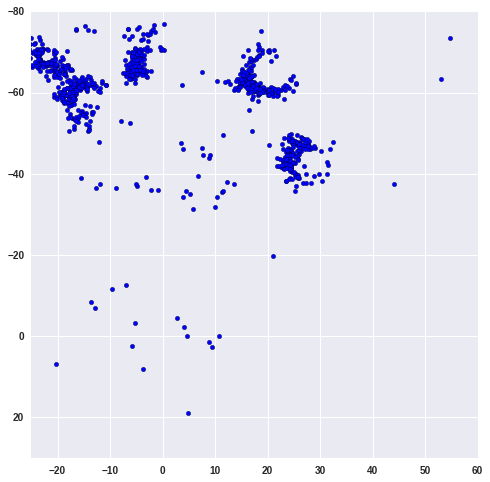

In [19]:
import matplotlib.pyplot as plt
import numpy
figure, axis = plt.subplots(figsize=(8, 8), dpi=600)
ax = axis
cmap = plt.get_cmap('jet')
scat = ax.scatter(fitDF['x'], fitDF['y'])
ax.set_xlim(-25, 60)
ax.set_ylim(30, -80)

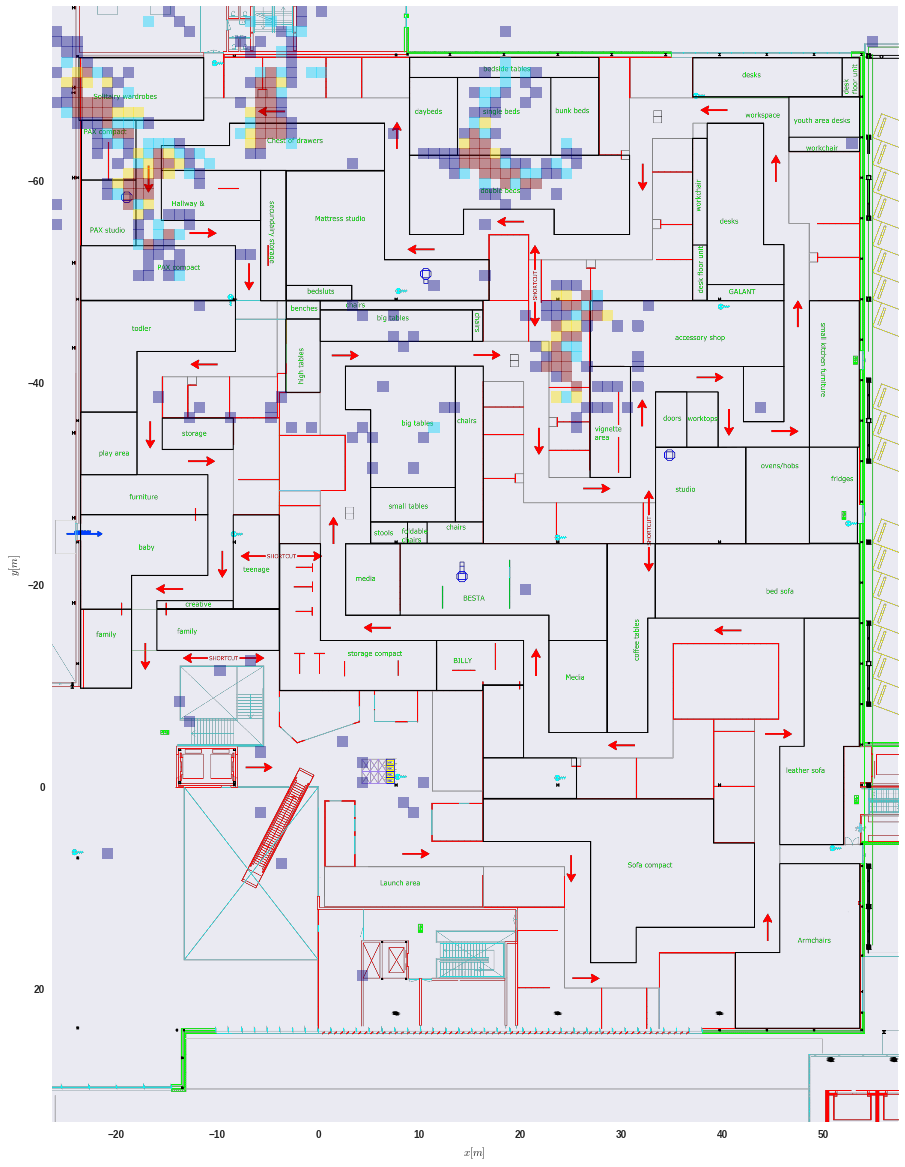

In [21]:
from skimage import io as skimg_io
def set_fig_properties():
    fig = plt.figure(figsize=(20, 20))
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_xbound(-26.34, 57.36)
    ax.set_ybound(-77.27, 33.13)
    bckgnd = skimg_io.imread('data/map_v2.png')
    ax.imshow(bckgnd, extent=[-26.34, 57.36, 33.13, -77.27])
    ax.set_xlabel("$x [m]$")
    ax.set_ylabel("$y [m]$")
    return fig, ax

fig, ax = set_fig_properties()


h_unimac,xbin,ybin = np.histogram2d(fitDF['x'], fitDF['y'], [83, 110], 
                                         [[-26.34, 57.36], [-77.27, 33.13]])      
h = np.rot90(h_unimac)
h = np.flipud(h)
hmasked = np.ma.masked_where(h==0,h)
     
hm = plt.pcolormesh(xbin, ybin, hmasked, cmap= cm.jet,vmin=1, vmax =4, alpha=0.40)

## Plot the fitted transmitted power of all WiFi devices

In [ ]:
from scipy.stats import norm
import matplotlib.mlab as mlab
# best fit of data
(mu, sigma) = norm.fit(fitDF['pT'])

# the histogram of the data
n, bins, patches = plt.hist(fitDF['pT'], 20, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Fitted transmitted power')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ pT:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
#plt.savefig('Offset_with_env_y{0}_{1}.png'.format(devices[0],pos)) 